In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
df = pd.read_csv('../data/occupation_shares.csv')
df = df.iloc[:-1]
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
df = df.set_index('MET2013')

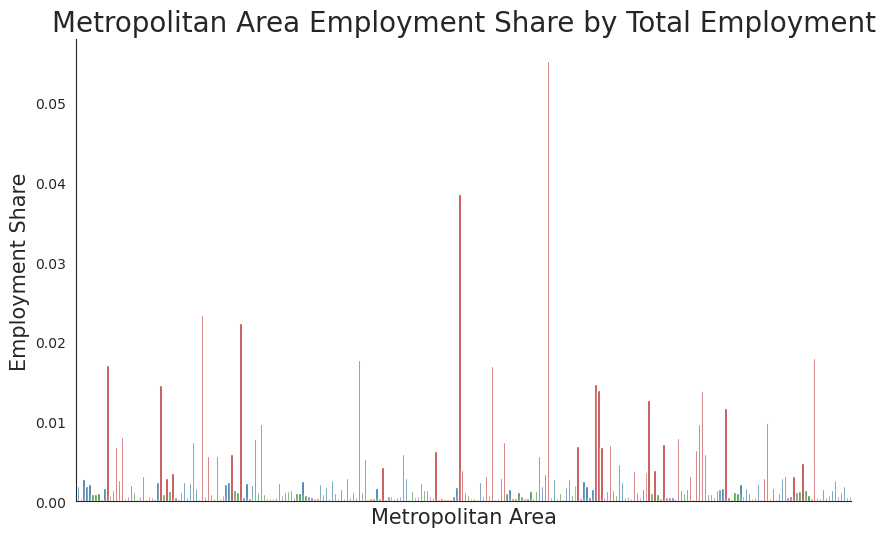

In [3]:
df['index'] = range(len(df))

# Define the colors for the quintiles
colors = ['blue', 'green', 'yellow', 'orange', 'red']

# Divide the 'city_total' column into quintiles
quintiles = pd.qcut(df['city_total'].iloc[1:], 5, labels=False)

# Map each quintile to a color
df['color'] = quintiles.map(lambda x: colors[x])

plt.figure(figsize=(10, 6))  # Increase the figure size
sns.set_style("white")  # Set the style of the plot to 'white'
barplot = sns.barplot(x='index', y='city_total', data=df.iloc[1:], hue='color', dodge=False)  # Use the colors
barplot.legend_.remove()  # Remove the legend
plt.title('Metropolitan Area Employment Share by Total Employment', fontsize=20)  # Add a title and increase the font size
plt.xlabel('Metropolitan Area', fontsize=15)  # Increase the font size of the x-label
plt.ylabel('Employment Share', fontsize=15)  # Increase the font size of the y-label
plt.xticks([])  # Remove x-axis labels
sns.despine()  # Remove the box around the plot
plt.savefig('graphs/city_employment_share.png')
plt.show()

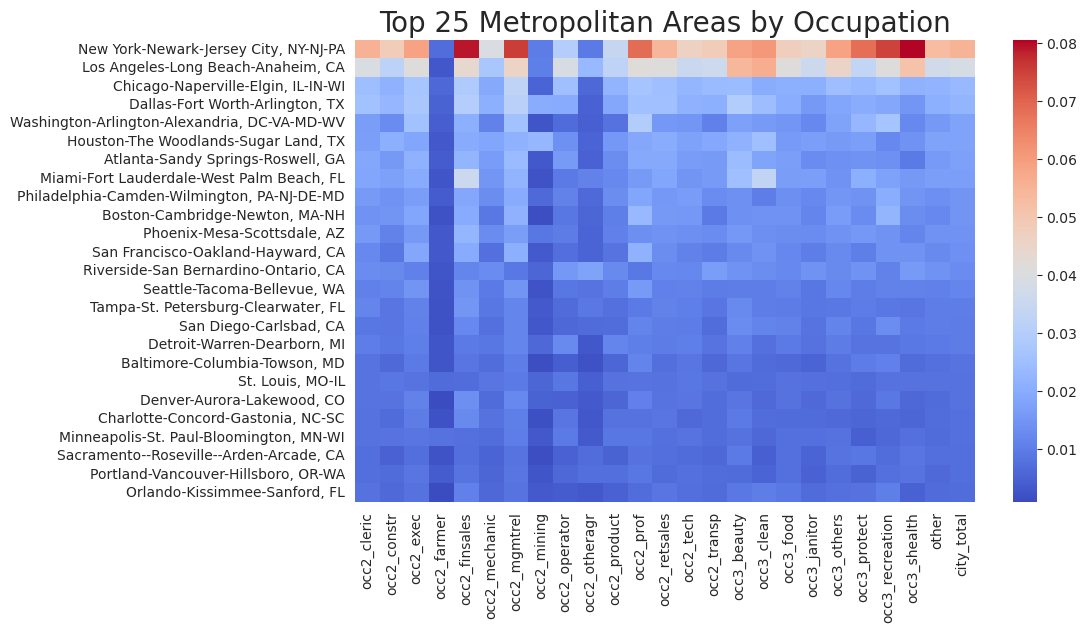

In [4]:
df = df.drop(columns=['index', 'color'])

# Sort the DataFrame by 'city_total' in descending order and select the top 25 rows
df_top25 = df.iloc[1:].sort_values('city_total', ascending=False).head(25)

plt.figure(figsize=(10, 6))  # Increase the figure size
sns.heatmap(df_top25, annot=False, cmap='coolwarm', cbar_kws={'label': ''})  # Create a heatmap without a colorbar label
plt.title('Top 25 Metropolitan Areas by Occupation', fontsize=20)  # Add a title and increase the font size
plt.xlabel('')  # Remove the x-label
plt.ylabel('')  # Remove the y-label
plt.savefig('graphs/top_25_occupation_heatmap.png')
plt.show()

In [5]:
df = pd.read_csv('../data/met_occupation.csv')
df.set_index('MET2013', inplace=True)
df = df.iloc[1:]
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce').fillna(0)
df.iloc[-1].name = 'Occupation Total'
df = df.div(df.iloc[:, -1], axis=0)


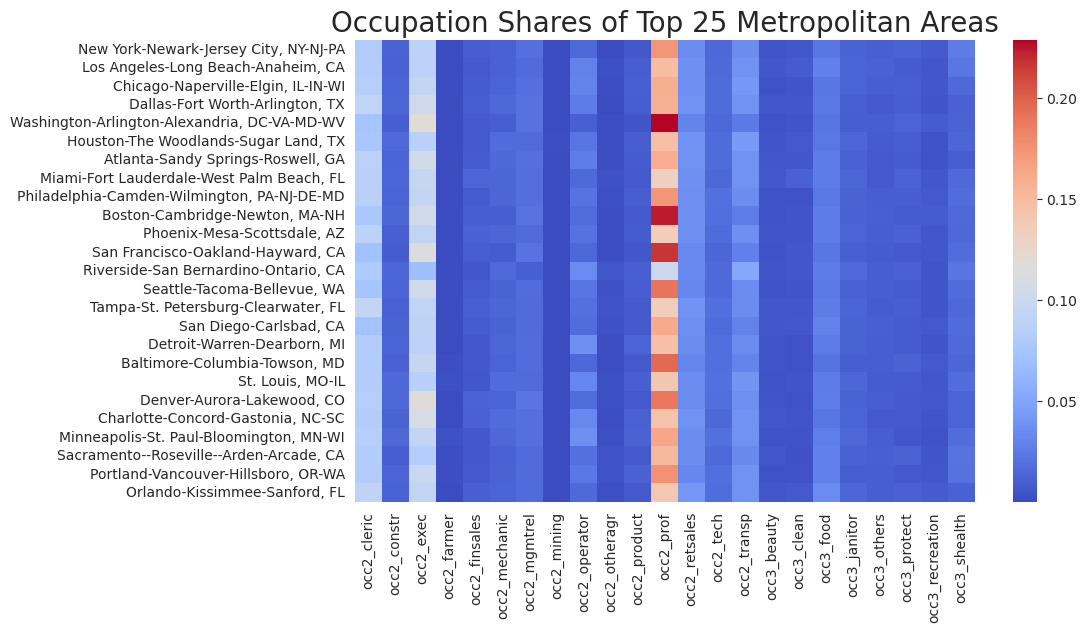

In [6]:
cities = df_top25.index.to_list()

df_top25 = df.loc[cities]
df_top25 = df_top25.drop(columns=['city_total', 'other'])

plt.figure(figsize=(10, 6))  # Increase the figure size
sns.heatmap(df_top25, annot=False, cmap='coolwarm', cbar_kws={'label': ''})  # Create a heatmap without a colorbar label
plt.title('Occupation Shares of Top 25 Metropolitan Areas', fontsize=20)  # Add a title and increase the font size
plt.xlabel('')  # Remove the x-label
plt.ylabel('')  # Remove the y-label
plt.savefig('graphs/top_25_city_heatmap.png')
plt.show()